Load in ref pixels for larger cropped area LS with western mountains 

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
%matplotlib  widget

In [2]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

Load in ref pixels mask made with 'choosing_reference_pixels.ipynb' notebook 

Reference pixel mask loaded.


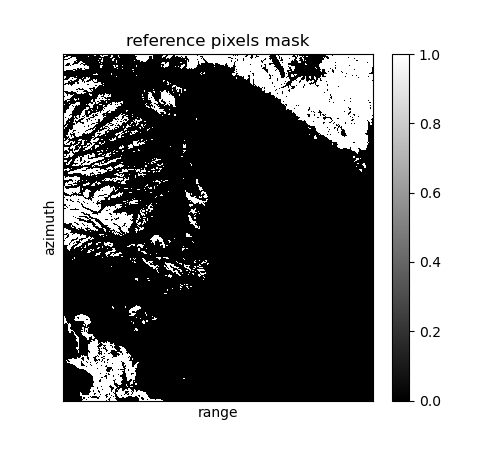

In [3]:
# load reference pixels mask 
#maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/masks/ref_pixels_mask.r4'
maskFile = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/masks/ref_pixels_mask.r4'
ds = gdal.Open(maskFile,gdal.GA_ReadOnly)
ref_mask = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
mask_y,mask_x = np.nonzero(ref_mask)
print('Reference pixel mask loaded.')

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

Gaussian filter the mask 

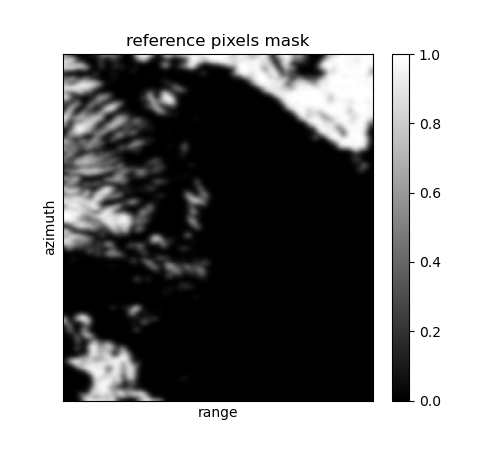

In [4]:
alooks=4*4
rlooks=20*4
ref_mask_filt = gaussian_filter(ref_mask,sigma = [alooks/2,rlooks/2])

# plot it 
plt.figure(figsize=(5,4.5))
plt.imshow(ref_mask_filt, cmap='gray',aspect='auto',interpolation='nearest',vmin=0,vmax=1.0); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

Load an igram and filter it.

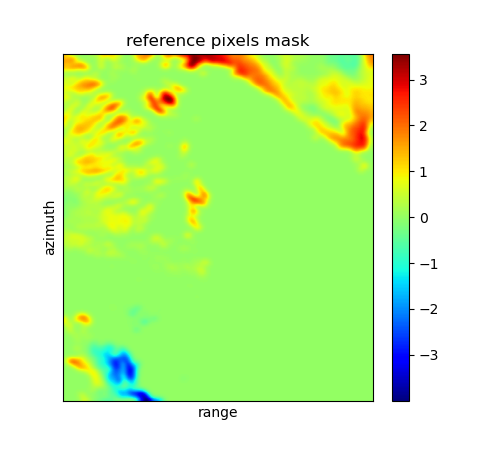

In [5]:
driver=gdal.GetDriverByName('ISCE')

# igramsDir is where the cropped, unwrapped igrams are
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

i = 24
igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
# find pixel locations that are the ref pixels 
masked_y,masked_x = np.nonzero(ref_mask)
# initialize igram_masked by starting with zeros, then replace good pix with their phase value
igram_masked = np.zeros((dy,dx))
igram_masked[masked_y,masked_x] = temp_igram[masked_y,masked_x]
# filter it
igram_filt = gaussian_filter(igram_masked,sigma = [alooks/2,rlooks/2])

# plot it 
plt.figure(figsize=(5,4.5))
plt.imshow(igram_filt, cmap='jet',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

Divide (masked, filt data) / (filt mask)

/tmp/ipykernel_14498/2361678197.py:1: RuntimeWarning: invalid value encountered in true_divide
  ab = igram_filt / ref_mask_filt


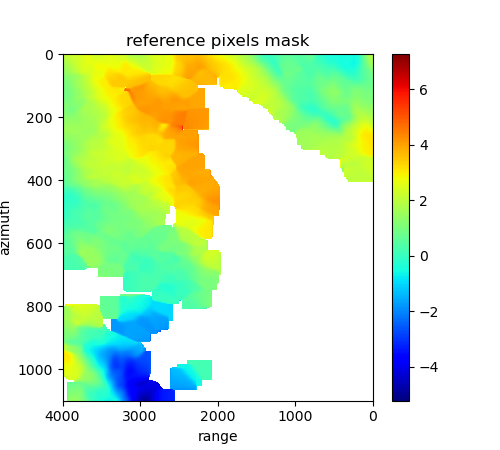

Mean phase value here: 1.418481719960776e+00


In [6]:
ab = igram_filt / ref_mask_filt

# plot it 
plt.figure(figsize=(5,4.5))
plt.imshow(ab, cmap='jet',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); #plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(); plt.show()

print('Mean phase value here: '+str(np.nanmean(ab)))

Load in an igram, extract "good" pixel values (from ref pix), interpolate the rest, save it as a ref ramp file.

In [ ]:
driver=gdal.GetDriverByName('ISCE')

# igramsDir is where the cropped, unwrapped igrams are
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'

# initialize temp ramp with nans
ramp_temp = np.empty((dy,dx))*np.nan

i = 2
igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
# put ref pixel phase values into ramp_temp 
ramp_temp[mask_y,mask_x] = temp_igram[mask_y,mask_x]

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(ramp_temp, cmap='viridis',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); #plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('reference pixels mask') 
plt.colorbar(label='unw phase (rad)'); plt.show()

# NEAREST
# now infill the nans with nearest interpolation, https://stackoverflow.com/questions/68197762/fill-nan-with-nearest-neighbor-in-numpy-array
mask = np.where(~np.isnan(ramp_temp))
interp = NearestNDInterpolator(np.transpose(mask),ramp_temp[mask])
ramp_to_save = interp(*np.indices(ramp_temp.shape))

# plot it to make sure it matches plot above.
plt.figure(figsize=(5,4.5))
plt.imshow(ramp_to_save, cmap='viridis',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); #plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('interpolated ramp from nearest reference pixels') 
plt.colorbar(label='unw phase (rad)'); plt.show()

# LINEAR and then nearest to fill edges
# now infill the nans with linear interpolation, https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator
mask2 = np.where(~np.isnan(ramp_temp))
interp2 = LinearNDInterpolator(np.transpose(mask2),ramp_temp[mask2])
ramp_to_save2 = interp2(*np.indices(ramp_temp.shape))
# then do nearest to fill in the very edges
# mask3 = np.where(~np.isnan(ramp_to_save2))
# interp3 = NearestNDInterpolator(np.transpose(mask3),ramp_temp[mask3])
# ramp_to_save2 = interp3(*np.indices(ramp_temp.shape))

# plot it, compare to nearest interp.
plt.figure(figsize=(5,4.5))
plt.imshow(ramp_to_save2, cmap='viridis',aspect='auto',interpolation='nearest'); 
plt.xlim(dx,0); #plt.xticks([]); plt.yticks([])
plt.xlabel('range'); plt.ylabel('azimuth'); plt.title('linearly interpolated reference pixels') 
plt.colorbar(label='unw phase (rad)'); plt.show()

Now try something different: filter the igram (smears out the good pixels) = A, filter the mask = B, divide A/B, take the mean phase value and use it as reference. 

In [ ]:
driver=gdal.GetDriverByName('ISCE')
# igramsDir is where the cropped, unwrapped igrams are
igramsDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/unfilt_unwrapped/'
saveDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/ramps_to_use_as_refs/'
# initialize temp ramp with nans
ramp_temp = np.empty((dy,dx))*np.nan

for i in range(numIgrams): # numIgrams if doing all of them at once
    igramFile = igramsDir+dates[i]+'_'+dates[i+1]+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    temp_igram = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
    # put ref pixel phase values into ramp_temp 
    ramp_temp[mask_y,mask_x] = temp_igram[mask_y,mask_x]

    # now infill the nans with nearest interpolation
    mask = np.where(~np.isnan(ramp_temp))
    interp = NearestNDInterpolator(np.transpose(mask),ramp_temp[mask])
    ramp_to_save = interp(*np.indices(ramp_temp.shape))

    fileName = dates[i]+'_'+dates[i+1]+'_ramp.r4'
    colds = driver.Create(saveDir+fileName,dx,dy,1,gdal.GDT_Float32)
    colds.GetRasterBand(1).WriteArray(ramp_to_save)
    colds=None

    print('Ramp file '+str(i)+' saved.')